# Tutorial for using the Fitness Landscape Sequence Design Simulator

* [Building oracles for landscapes](#section-one)
* [Building a model of the landscape](#section-two)
* [Exploring a landscape with a model](#section-three)
* [Evaluating an exploration algorithm](#section-four)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/') 
sys.path.append('../')
import RNA 

## 1. Building oracles for landscapes <a class="anchor" id="section-one"></a>

In [3]:
from models.Ground_truth_oracles.RNA_landscape_models import RNA_landscape_constructor

In [4]:
landscape_constructor = RNA_landscape_constructor()
#load a pre-specified landscapes  (here, index 0), you can also specify to just take a few of them
landscape_constructor.load_landscapes("../data/RNA_landscapes/RNA_landscape_config.yaml", landscapes_to_test=[0])
landscape_generator = landscape_constructor.generate_from_loaded_landscapes()

B1L14RNA1 loaded


In [5]:
landscape_constructor.loaded_landscapes

[{'B1L14RNA1': {'self_fold_max': False,
   'seq_size': 14,
   'conserved_start': False,
   'conserved_pattern': False,
   'targets': ['GAACGAGGCACAUUCCGGCUCGCCCGGCCCAUGUGAGCAUGGGCCGGACCCCGUCCGCGCGGGGCCCCCGCGCGGACGGGGGCGAGCCGGAAUGUGCCUC'],
   'starts': {'startRNAL14_0': 'AUGGGCCGGACCCC',
    'startRNAL14_1': 'GCCCCGCCGGAAUG',
    'startRNAL14_2': 'UCUUGGGGACUUUU',
    'startRNAL14_3': 'GGAUAACAAUUCAU',
    'startRNAL14_4': 'CCCAUGCGCGAUCA'}}}]

In [6]:
#take one landscape oracle from the generator
landscape_object=next(landscape_generator)

In [7]:
print(landscape_object['landscape_id'])
print (landscape_object['starting_seqs'])

B1L14RNA1
{'startRNAL14_0': 'AUGGGCCGGACCCC', 'startRNAL14_1': 'GCCCCGCCGGAAUG', 'startRNAL14_2': 'UCUUGGGGACUUUU', 'startRNAL14_3': 'GGAUAACAAUUCAU', 'startRNAL14_4': 'CCCAUGCGCGAUCA'}


In [8]:
landscape_oracle = landscape_object['landscape_oracle']

You can now query the landscape for ground truth sequence fitnesses, note: you should never do this when testing an algorithm, landscapes should be accessed through their approximators (so that your number of measurments are recorded)

In [9]:
landscape_oracle.get_fitness('GGAUAACAAUUCAU')

0.14554841726711917

While we show this process on RNA landscapes there are other empirical landscapes that we have similar wrappers around. You can also make your own *custom* landscapes, but making RNA landcsapes with different targets, or a combination of targets (see the RNA_landscape_model_constructor for examples of how these can be made). 

## 2. Building a model of the landscape <a class="anchor" id="section-two"></a>

In reality, you don't have access to the ground truth landscape oracles except through costly experiments. Instead you can access an approximate version of it either by modeling the landscape through your current observations. In section 2.1 we use an abstract model to simulate the situation where you have a model with arbitrary noise. In section 2.2 we show some standard neural nets and use them as models of the landscape. It is easy to implement your own model. All they need to do is to implement `_fitness_function(sequence)` which gives you the model's estimate of a sequences fitness, and `update_model([sequence1, sequence2,...])` which will pay a cost to learn on the true labels of sequences.

### 2.1. Null model

The null model is the most simple model of the landscape. At each epoch, the model guesses the fitness of a variant by drawing a random sample from the exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = \mathbb{E}[f_\text{measured_sequences}]$. 

In [10]:
from models.Noisy_models.Noisy_abstract_model import Null_model

In [11]:
null_model = Null_model(landscape_oracle)

We want to "measure" the true fitness of at least one sequence to start with (otherwise we can't have a model). We can do that by calling `measure_true_landscape` on the noisy model. This will charge you a "measurment cost", but in return tells you the true fitness of the sequence. When starting out or reusing the landscape, `reset` lets you zero the cost in the landscape, and if you pass it any sequences, it will measure those.  

In [12]:
wt = landscape_object['starting_seqs']['startRNAL14_3'] # any start sequence can be used, 
                                            #we picked a few for you to use that 
                                            #are diverse in sequence and performance
print(wt)

null_model.reset([wt])
print (f'cost of measurement: {null_model.cost}')


GGAUAACAAUUCAU
cost of measurement: 1


let's ask it for the fitness of a random sequence (we will show more complex results later).

In [13]:
null_model.get_fitness('UUAUAACAAUUCAU'), landscape_oracle.get_fitness('UUAUAACAAUUCAU')

(0.08563310735388958, 0.08787828781766369)

### 2.2 Abstract model 

This is an abstract model that "emulates" a real model of the landscape. It works by guessing the fitness of a new sequence as a combination of it's real fitness and fitness of the closest known neighbor. 

In [14]:
from models.Noisy_models.Noisy_abstract_model import Noisy_abstract_model

To build a noisy model, you need to have an oracle, and a `signal_strength` $\alpha \in [0,1]$. This parameter $\alpha$ determines how much your oracle signal is corrupted by noise:

$f_{model}= \alpha^d f_{oracle} + (1-\alpha^d)\epsilon$

here $d$ is the distance to the closest measured neighbor, and $\epsilon$ is a sample from an exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = f_\text{closest_neighbor}$ (for each queried sample, this is sampled once and then fixed for that batch). 

In [15]:
noisy_model_1 = Noisy_abstract_model(landscape_oracle, signal_strength=1)
noisy_model_2 = Noisy_abstract_model(landscape_oracle, signal_strength=0.9)
noisy_model_3 = Noisy_abstract_model(landscape_oracle, signal_strength=0.75)
noisy_model_4 = Noisy_abstract_model(landscape_oracle, signal_strength=0.0)
noisy_models=[noisy_model_1,noisy_model_2,noisy_model_3,noisy_model_4]

In [16]:
for noisy_model in noisy_models:
    noisy_model.reset([wt])


Let's measure the fitness of some samples through the model

In [17]:
from utils.sequence_utils import generate_random_mutant

In [18]:
mutation_rate = 0.5
RNA_alphabet = "UCGA" 
samples = [generate_random_mutant(wt, mutation_rate, alphabet= RNA_alphabet) for i in range(10000)]
samples[:5]

['GGAGAGCAGAUAAC',
 'GGGAACCAAGUGAU',
 'GGAUGCCAAAUCUC',
 'GCAAAACUAUUCUC',
 'GGAUAGCGAUACAU']

In [19]:
from scipy.stats import pearsonr,spearmanr 

/anaconda3/envs/tf3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


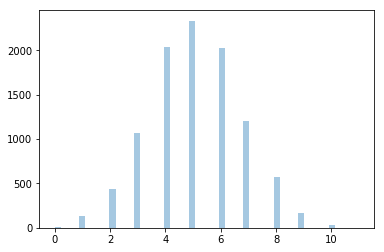

In [20]:
distances = []
for sequence in samples:
    distances.append(editdistance.eval(sequence, wt))
    
sns.distplot(distances, kde=False)

In [21]:
def get_corr_per_distance(samples,distances, model):
    corrs=[]
    for i in range(1,11):
        samples_at_distance=[]
        for j in range(len(samples)):
            if distances[j]==i:
               samples_at_distance.append(samples[j])
        if len(samples_at_distance)>50:
            corrs.append(pearsonr(np.array([landscape_oracle.get_fitness(x) for x in samples_at_distance]),\
                              np.array([model.get_fitness(x) for x in samples_at_distance]))[0]**2)
        else:
            corrs.append(np.nan)
    return corrs

In [22]:
corrs = [get_corr_per_distance(samples,distances,noisy_model) for noisy_model in noisy_models] 
corrs_null = get_corr_per_distance(samples, distances, null_model)

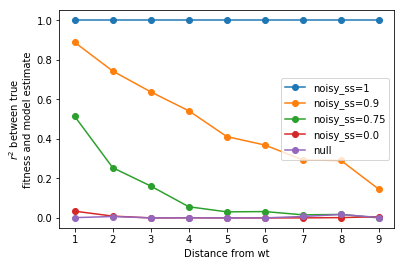

In [23]:
plt.plot(range(1,11),corrs[0],'o-', label="noisy_ss=1")
plt.plot(range(1,11),corrs[1],'o-', label="noisy_ss=0.9")
plt.plot(range(1,11),corrs[2],'o-', label="noisy_ss=0.75")
plt.plot(range(1,11),corrs[3],'o-', label="noisy_ss=0.0")
plt.plot(range(1,11),corrs_null,'o-',label="null")
plt.ylabel("$r^2$ between true\nfitness and model estimate")
plt.xlabel("Distance from wt")
plt.legend()

In [7]:
from models.Noisy_models.Ensemble import Ensemble_models

In [77]:
ensemble = Ensemble_models(noisy_models)

In [78]:
ensemble.reset([wt])

In [79]:
ensemble.get_fitness('GGAUGCCAAAUCUC')

0.21756534328435323

In [80]:
ensemble.get_fitness_distribution('GGAUGCCAAAUCUC')

[0.2581424561418565,
 0.1857532404249852,
 0.07149675568498695,
 0.35486892088558436]

### 2.3 Models of landscapes built from data

Similarly, we can approximate the landscape by training a model on it. Some basic architectures are provided for convenience. 

In [6]:
from utils.model_architectures import Linear, NLNN, CNNa
from models.Noisy_models.Neural_network_models import NN_model

Using TensorFlow backend.


For real models, it's more sensible to train them on more than just the WT

In [58]:
training_sequences = list(set([generate_random_mutant(wt,0.2, RNA_alphabet) for i in range(0,500)]))
print (f'training data consisted of {len(training_sequences)} unique sequences')

training data consisted of 352 unique sequences


In [63]:
linear_architecture=Linear(len(wt), alphabet=RNA_alphabet)
noisy_lnn_model=NN_model(landscape_oracle,linear_architecture)
noisy_lnn_model.reset()
noisy_lnn_model.update_model(training_sequences)
corrs_LNN= get_corr_per_distance(samples,distances,noisy_lnn_model)

In [64]:
global_epistasis_architecture=NLNN(len(wt), alphabet=RNA_alphabet)
noisy_gnn_model=NN_model(landscape_oracle,global_epistasis_architecture)
noisy_gnn_model.reset()
noisy_gnn_model.update_model(training_sequences)
corrs_NLNN= get_corr_per_distance(samples,distances,noisy_gnn_model)

In [65]:
cnn_architecture=CNNa(len(wt), alphabet=RNA_alphabet)
noisy_cnn_model=NN_model(landscape_oracle,cnn_architecture)
noisy_cnn_model.reset()
noisy_cnn_model.update_model(training_sequences)
corrs= get_corr_per_distance(samples,distances,noisy_cnn_model)

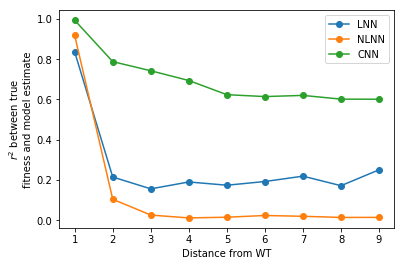

In [66]:
plt.plot(range(1,11),corrs_LNN,'o-', label="LNN")
plt.plot(range(1,11),corrs_NLNN,'o-', label="NLNN")
plt.plot(range(1,11),corrs,'o-', label="CNN")
plt.ylabel("$r^2$ between true\nfitness and model estimate")
plt.xlabel("Distance from WT")
plt.legend()

We can easily ensemble these models of the landscape as well. 

In [81]:
ensemble = Ensemble_models([noisy_lnn_model,noisy_gnn_model,noisy_cnn_model])

In [86]:
ensemble.reset(training_sequences)

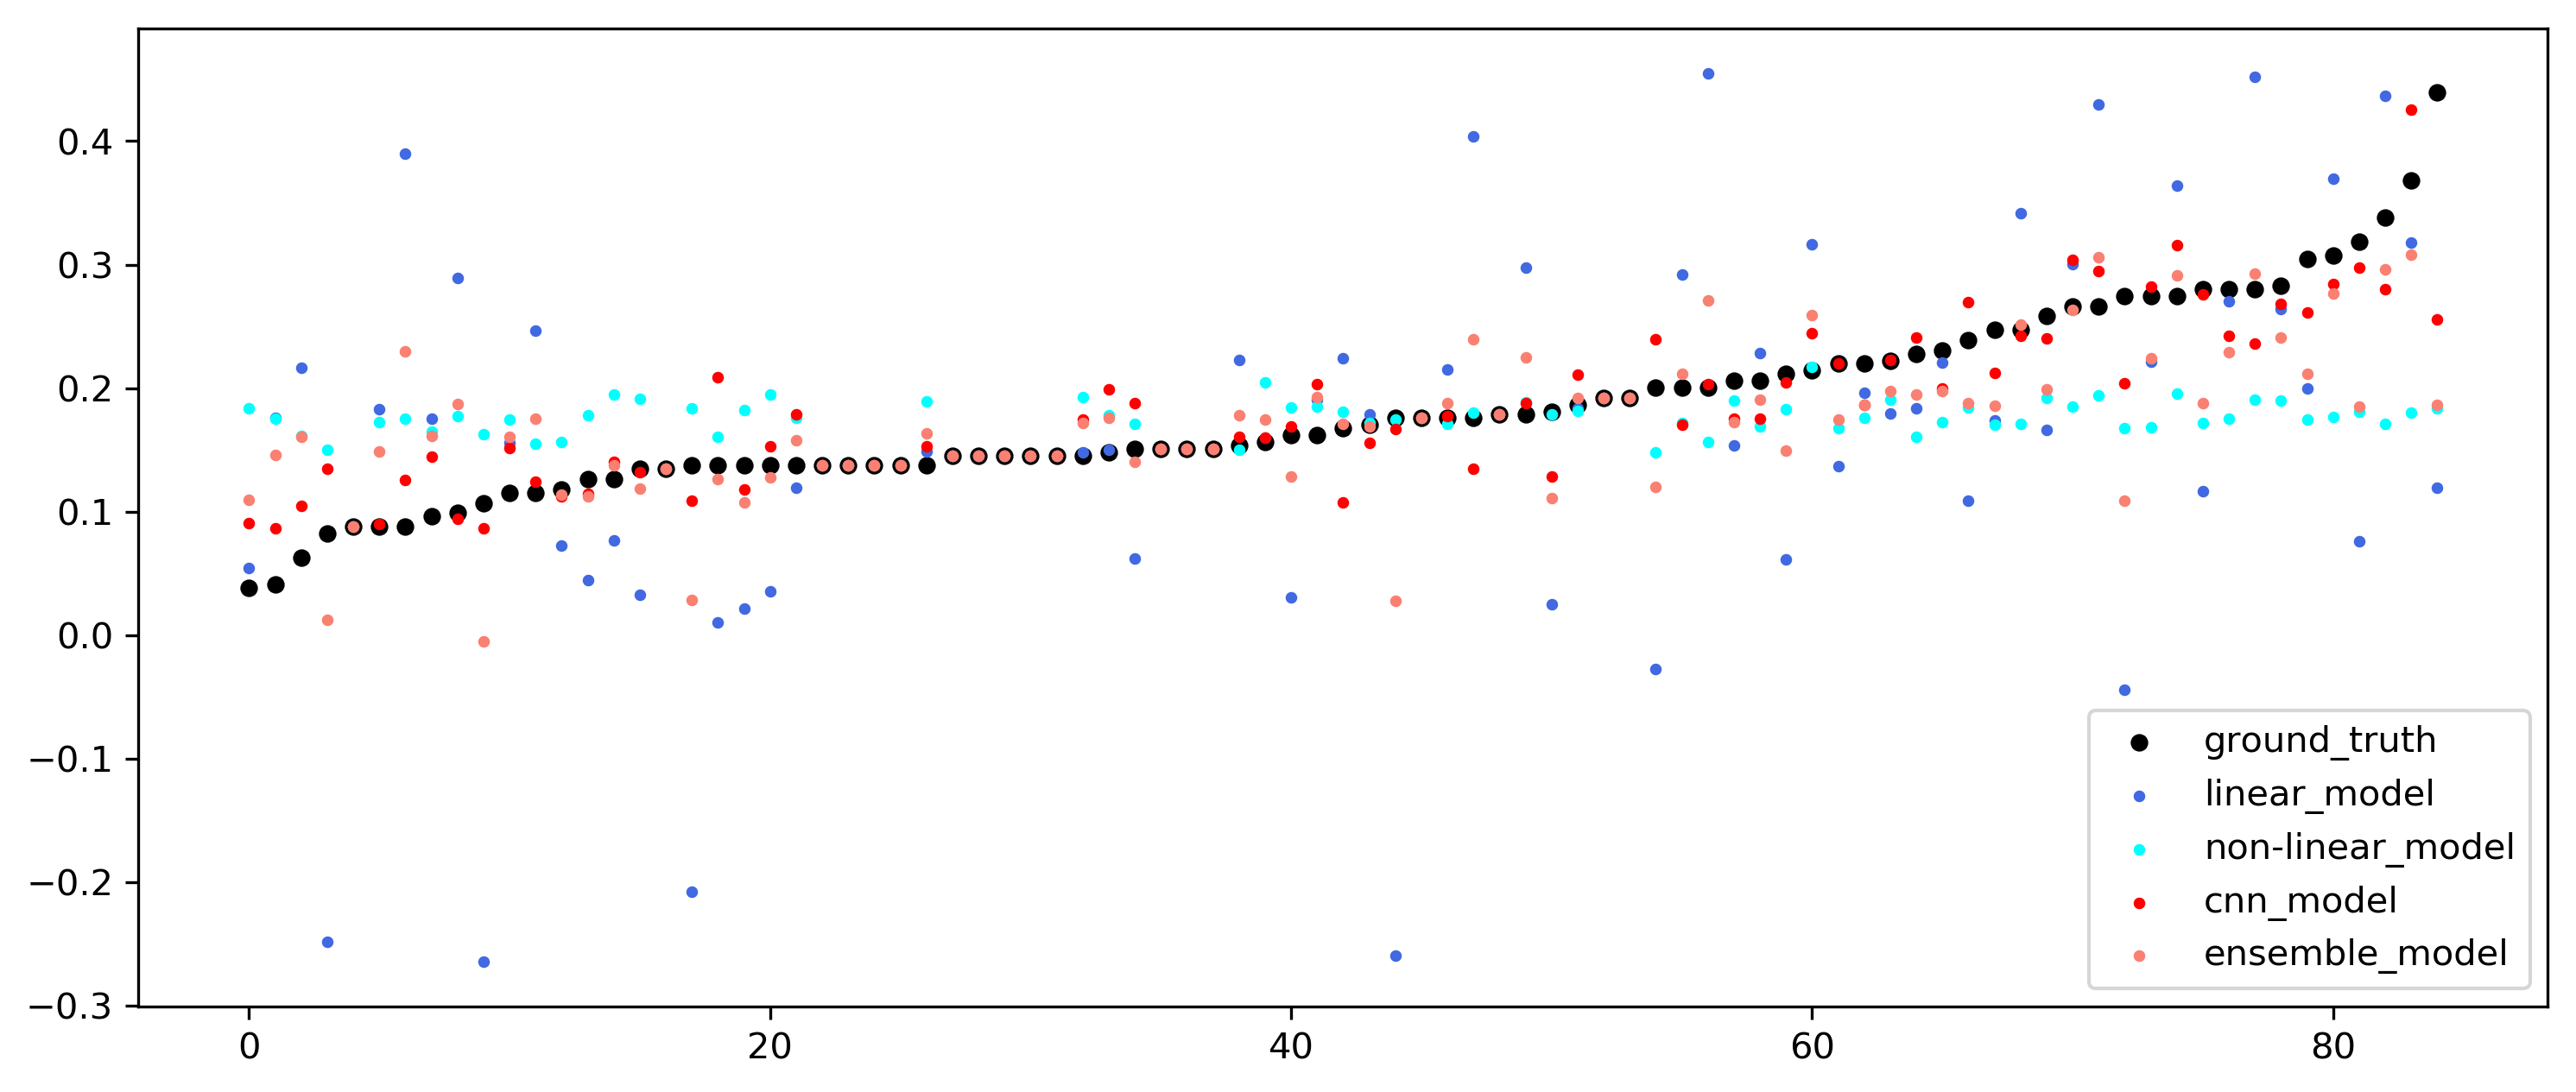

In [111]:
plt.figure(figsize=(12,5),dpi=300)
test_sequences = list(set([generate_random_mutant(wt,0.2, RNA_alphabet) for i in range(0,100)]))
lnn_preds = []
gnn_preds = []
cnn_preds = []
real_fitnesses = []
all_fitnesses = [ ]
for sequence in test_sequences:
    all_fitnesses.append((landscape_oracle.get_fitness(sequence),ensemble.get_fitness_distribution(sequence), ensemble.get_fitness(sequence)))

all_fitnesses = sorted(all_fitnesses)
lnn_preds = [x[1][0] for x in all_fitnesses]
gnn_preds = [x[1][1] for x in all_fitnesses]
cnn_preds = [x[1][2] for x in all_fitnesses]
ensemble_preds = [x[2] for x in all_fitnesses]

real_fitnesses = [x[0] for x in all_fitnesses]

plt.scatter(range(len(test_sequences)), real_fitnesses,c="k", s=15, label="ground_truth")
plt.scatter(range(len(test_sequences)), lnn_preds, c="royalblue",s=5,label="linear_model")
plt.scatter(range(len(test_sequences)), gnn_preds, c="cyan",s=5,label="non-linear_model")
plt.scatter(range(len(test_sequences)), cnn_preds, c="red",s=5,label="cnn_model")
plt.scatter(range(len(test_sequences)), ensemble_preds, c="salmon",s=5,label="ensemble_model")
plt.legend()

Now that we have models, we can use them with an exploration algorithm to search the landscape. 

## 3. Exploring the landscape with a model <a class="anchor" id="section-three"></a>

All exploration algorithms in this package inherit from `Base_explorer` which performs some house-keeping tasks. We recommend doing the same when you "bring your own" explorer. It's very easy to implement an explorer in this framework, all it needs to implement is a `propose_sequences` method, that suggest new sequences for which a "costly" measurment to the oracle is performed.  

In [29]:
from explorers.base_explorer import Random_explorer

In [30]:
mutation_rate = 0.05
explorer1 = Random_explorer(mutation_rate, batch_size = 100, alphabet= RNA_alphabet, virtual_screen = 10)

- `batch_size` denotes the experimental batch size
- `virtual_screen` is the number of computational queries to the model that is allowed per batch. 
- `alphabet` is the alphabet that is permissive on the current landscape.

In [31]:
explorer1.debug = True #don't save any results
explorer1.set_model(noisy_nn_model)

In [32]:
num_of_rounds = 5
explorer1.run(num_of_rounds, verbose=True)

round: 0, cost: 357, evals: 958, top: 0.4476300009492011
round: 1, cost: 457, evals: 1054, top: 0.4476300009492011
round: 2, cost: 557, evals: 1154, top: 0.538254515338481
round: 3, cost: 657, evals: 1254, top: 0.538254515338481
round: 4, cost: 757, evals: 1354, top: 0.538254515338481


Let's see what was printed:
- The number of **rounds** represents how many experiments was done
- The **cost** shows how many total calls to the oracle was made (experimental cost). Because training the model had an overhead, that is accounted in the total cost. 
- The **evals** shows how many total calls to the model was made (computational cost).
- **Top** simply lists the top fitness (cumulative) observed through the exploration

## 4. Evaluating an exploration algorithm <a class="anchor" id="section-four"></a>


In [33]:
from evaluators.Evaluator import Evaluator

Pick the landscapes you want to run the evaluation suite on. This can be done by including indexes or "all" which results in loading all pre-defined landscapes. 

**WARNING**: Running evaluators on all landscapes would take forever if not done in a parallel fashion. Debug your process with a couple of landscapes first. We recommend sending each evaluation-landscape pair to a separate worker.  

In [34]:
LANDSCAPE_TYPES ={"RNA": [2,3],"TF": [1]}#["GFP": "all","ADDITIVE":"all"]


In [36]:
evaluator=Evaluator(explorer1,landscape_types=LANDSCAPE_TYPES, path="../simulations/eval/")\
                                                                    #path to where the results are saved

loading landscapes RNA: [2, 3], TF:[1]
B1L100RNA1 loaded
B1L14RNA2 loaded
1 TF landscapes loaded.
loading complete


The evaluator can run tests aimed at different properties of the explorer. 

The tests include:
- `consistency_robustness_independence`: shows how explorer performance changes given different models.
- `efficiency`: shows how explorer performance changes when more computational evals are allowed
- `adaptivity`: shows how the explorer is sensitive to the number of batches it is allowed to sample
- `scalability`: shows how fast the explorer produces a batch. 

Note that once you run a particular test (among these), if you want to run more tests, you need to re-run `load_landscapes` on the evaluator (as the generator stack is depleted.  

In [ ]:
evaluator.evaluate_for_landscapes(evaluator.adaptivity,\
                                  num_starts=1) #num starts determines how many starting points
                                                #should be tested per landscape